# Exploring LFP spectra along an M1 shank
Examined the spectral properties of M1 along its laminar axis.

In [115]:
import os
import sys
import pywt

# add the path to the parent directory to augment search for module
sys.path.append('../code/') # for relative import in jupyter notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from preprocess.lfp import make_lfp_file_spikeglx

### Calculate the LFP and save as binary file

imec1 was recorded from a single shank spanning the dorsal-ventral axis of M1.

In [3]:
# binary data to load
bin_path = os.path.join("D:","SortingTest","24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1",
                        "24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_imec1",
                        "24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_t0.imec1.ap.bin")

# read meta file
lfp_path = make_lfp_file_spikeglx(bin_path)

100%|██████████| 294/294 [4:49:50<00:00, 59.15s/it]  


In [21]:
# assuming we have 385 channels, let's determine the offsets that we need to read
# a 1 second epoch at the start of every minute of the recording.
n_channels = 385
n_samples = os.path.getsize(lfp_path)//2 # number of samples in the LFP data
epoch_dur = 10 # 1 second epoch
fs = 1000 # sampling rate of the LFP data in Hz, 1000 samples per second
samps_per_sec = fs * n_channels # number of samples per second
epoch_offsets = np.arange(0, n_samples, samps_per_sec * 60).astype(np.int64) # offset in samples
epoch_count = epoch_dur * samps_per_sec # number of samples in an epoch

# create file object for LFP binary file
lfp_file = open(lfp_path, 'rb')

# read the data
data = np.zeros((len(epoch_offsets), epoch_dur * fs, n_channels), dtype=np.int16)
for i, offset in enumerate(epoch_offsets):
    lfp_file.seek(offset*2) # move the file pointer to the start of the epoch
    temp = np.fromfile(lfp_file, dtype=np.int16, count=epoch_count) # read the data
    data[i] = temp.reshape((-1, n_channels)) # reshape the data into a 2D array

# close the file
lfp_file.close()

Restrict analysis to 16 channels spaced evenly across the probe.

### Spectral analysis

In [26]:
# Create a continuous wavelet transform object
# We will use the complex Morlet wavelet
w = pywt.ContinuousWavelet('cmor2.5-1.0')

# parameters for our spectral analysis
start_freq = 1 # Hz
end_freq = 100 # Hz
num_freqs = 64 # number of frequencies to analyze

# Create a range of frequencies
freqs = np.geomspace(1, 100, 64) # space frequencies logarithmically
scales = pywt.frequency2scale(w, freqs) * fs # convert frequencies to scales

# Continuous wavelet transform
dt = 1/fs # time step in seconds
data_offset = data - np.mean(data, axis=1)[:, np.newaxis, :] # remove DC offset to minimize edge effects
data_cwt = np.zeros((len(data_offset), len(scales), epoch_dur * fs, data.shape[2]), dtype=np.complex128) # container for cwt
for epoch in range(len(data_offset)):
    for chan in range(data.shape[2]):
        cwtmatr, freqs = pywt.cwt(data_offset[epoch, :, chan], scales, w, sampling_period=dt)
        data_cwt[epoch, :, :, chan] = cwtmatr


In [28]:
mag = np.abs(data_cwt)

In [71]:
specs = np.median(mag[4], axis=1)

In [89]:
def zscore(x):
    return (x.T - np.mean(x, 1))/np.std(x, 1)

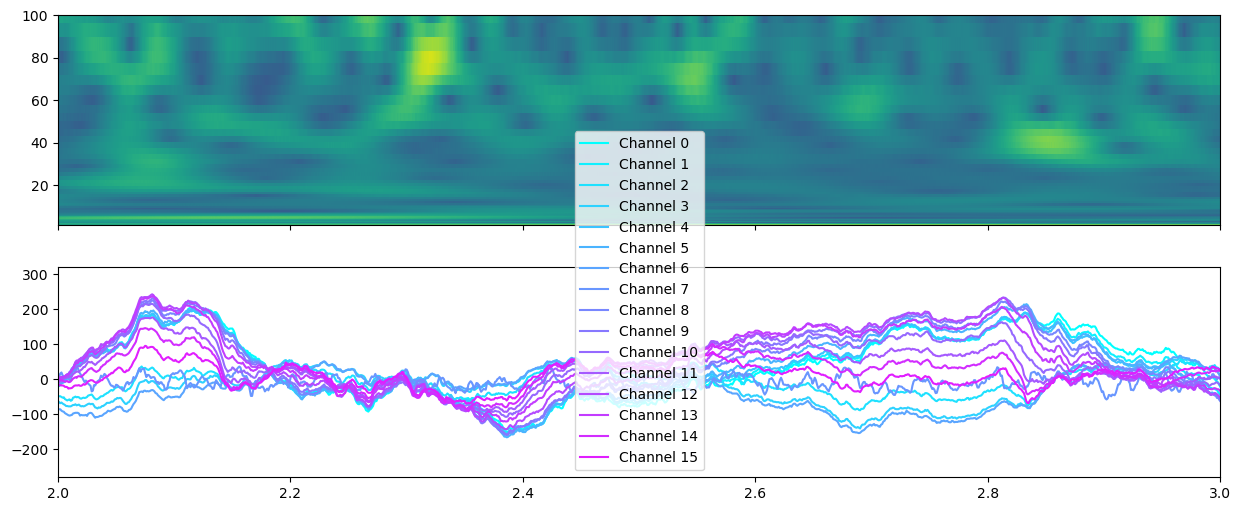

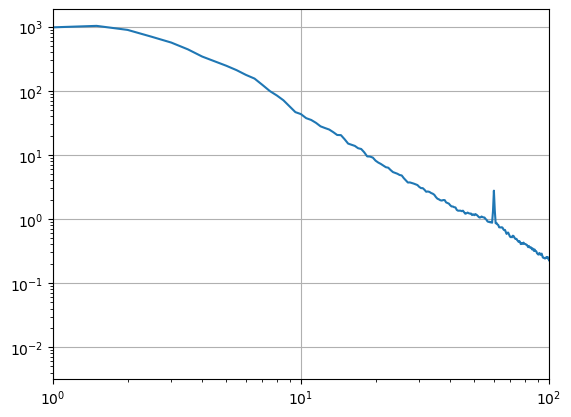

In [235]:
# create function to create a pcolor plot. The arguments are the data, the x-axis values, and the y-axis values
def pcolorplot(data, x, y, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    mesh = ax.pcolormesh(x, y, data, **kwargs)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    return mesh

ep = 270
ch = 5
fig, ax = plt.subplots(2,1,figsize=(15, 6), sharex=True)
pcolorplot(zscore(mag[ep, :, :, ch]).T, np.arange(mag.shape[2])/fs, freqs, ax=ax[0], vmin=-4, vmax=4)
plt.grid()
# have the line colors change from blue to red with the index of the line in data_offset
cmap = plt.cm.cool
for i in range(data_offset.shape[2]-1):
    ax[1].plot(np.arange(data_offset.shape[1])/fs, data_offset[ep, :, i], color=cmap(i/data_offset.shape[2]), label=f'Channel {i}')
plt.legend()
plt.grid()
plt.xlim([2, 3])
pxx = np.zeros((data_offset.shape[0], 1001))
for j in range(data_offset.shape[0]):
    f, pxx[j] = welch(data_offset[j, :, 8], fs, nperseg=fs*2, noverlap=fs/4)


plt.figure()
plt.plot(f[1:], np.mean(pxx[:,1:],0))
plt.xlim(1, 100)
plt.yscale('log')
plt.xscale('log')
plt.grid()


In [246]:
#all_spec = mag[:, :, :, 3].swapaxes(1, 2).reshape(-1, mag.shape[1]).T
all_spec = np.mean(mag[:, :, :, 14],axis=2).T

In [234]:
freqs[50]

38.6635375219241

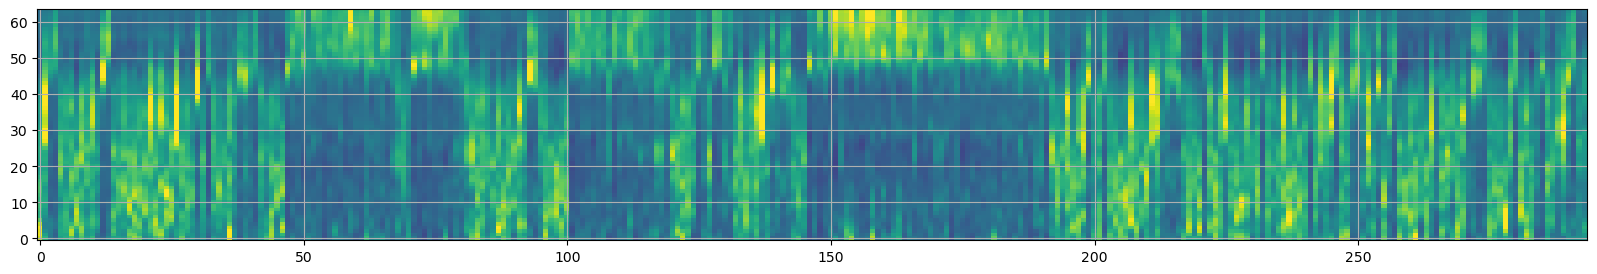

In [247]:
plt.figure(figsize=(20, 3))
plt.imshow(zscore(all_spec).T, vmin=-3, vmax=3, aspect='auto')
plt.gca().invert_yaxis()
plt.grid()

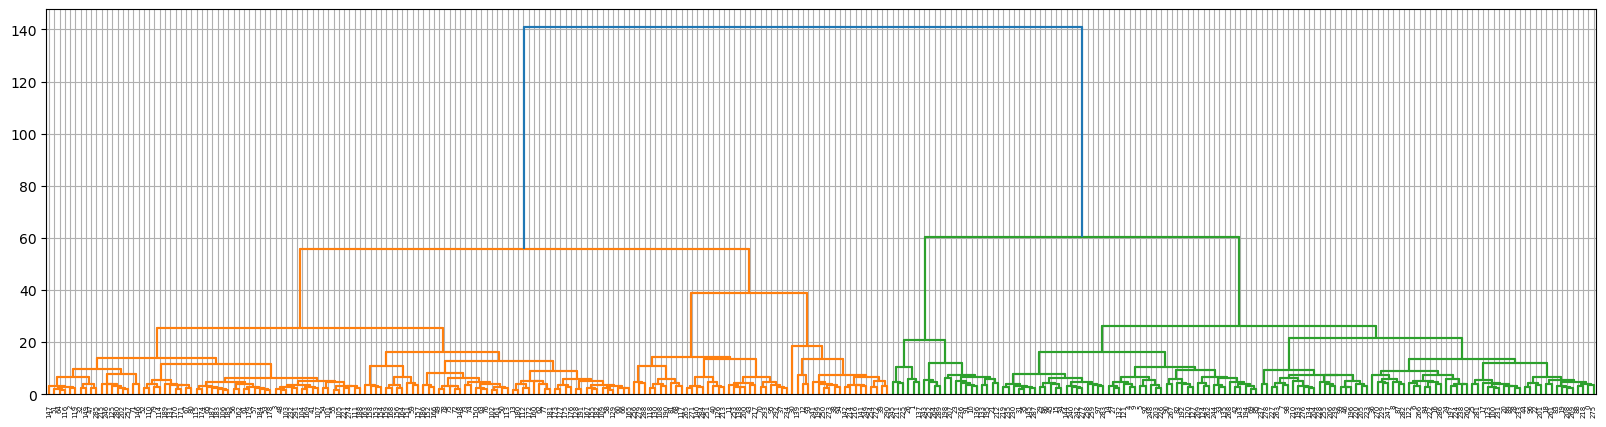

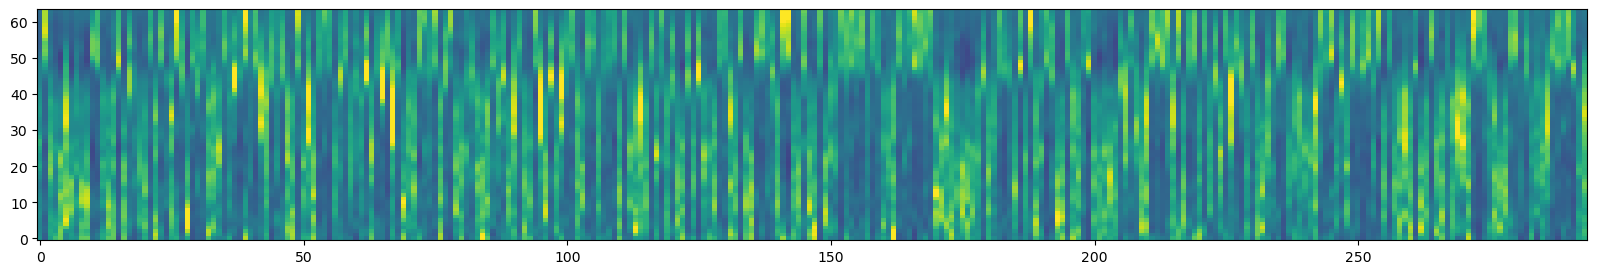

### Visualizing the LFP

Text(0.5, 1.0, 'LFP data from 5 channels, epoch 0')

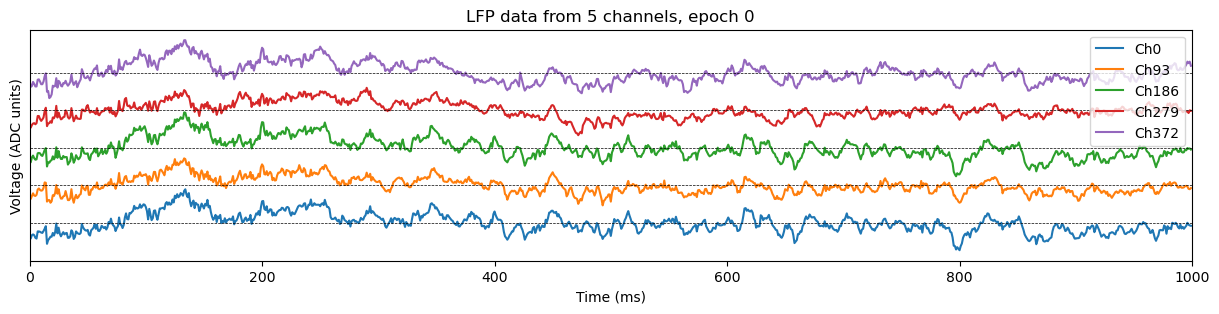

In [112]:
plt.figure(figsize=(15, 3))
sig_seps = np.array([0, 100, 200, 300, 400])
plt.plot((data[0, :, 0::93]-np.mean(data[0, :, 0::93], axis=0))+sig_seps)
for sep in sig_seps:
    plt.axhline(sep, color='k', linewidth=0.5, linestyle='--')
plt.xlim(0, 1000)
plt.legend(['Ch0', 'Ch93', 'Ch186', 'Ch279', 'Ch372'])
plt.yticks([])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (ADC units)')
plt.title('LFP data from 5 channels, epoch 0')